In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2

In [3]:
class DummyEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = tv.models.resnet50(pretrained=True)
        self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
        self.encoded_channels=1024
    
    def forward(self, image):
        a = self.extractor(image)
        return {
            'early': a['layer3_conv3'],
            'middle': a['layer3_conv3'],
            'deep': a['layer3_conv3'],
        }

In [119]:
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.6)
image = Image.open('/home/mark/Downloads/test.jpg')
image_np = np.array(image)
image = utils.preprocess_image(image_np)
image = torch.as_tensor(image)
image = torch.unsqueeze(image, 0)

keypoints, descriptors, scores, detections = extraction_model(image)

print(scores.size())
print(detections[0].shape)
row, col = np.nonzero(detections[0])
row *= image_np.shape[0]

plt.imshow(image_np)
plt.scatter(keypoints[:, 0], keypoints[:, 1])
row, col = np.nonzero(detections[0])
row = row.astype(np.float32)
col = col.astype(np.float32)
row *= image_np.shape[0]/detections[0].shape[0]
col *= image_np.shape[1]/detections[0].shape[1]
plt.scatter(col+8, row+8)
row, col = np.nonzero(detections[1])
row = row.astype(np.float32)
col = col.astype(np.float32)
row *= image_np.shape[0]/detections[1].shape[0]
col *= image_np.shape[1]/detections[1].shape[1]
plt.scatter(col+8, row+8)
row, col = np.nonzero(detections[2])
row = row.astype(np.float32)
col = col.astype(np.float32)
row *= image_np.shape[0]/detections[2].shape[0]
col *= image_np.shape[1]/detections[2].shape[1]
plt.scatter(col+8, row+8)
plt.show()
plt.imshow(detections[0])
plt.show()
plt.imshow(detections[1])
plt.show()
plt.imshow(detections[2])

AttributeError: 'NoneType' object has no attribute 'norm'

In [126]:
pair_idx = 2
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

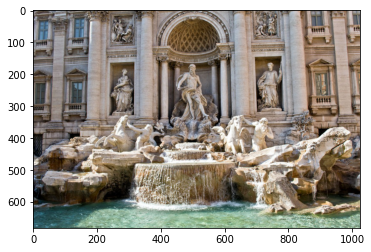

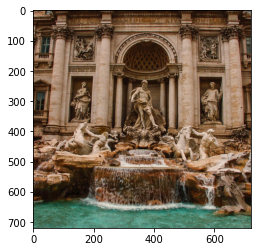

In [127]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [128]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = autoencoder.FeatureEncoder1.load_from_checkpoint('/home/mark/eth/enc.ckpt', load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=3, thresh=0.2)

In [129]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]

print(scores1)
print(scores2)

352 --> 352
238 --> 238
tensor([0.2498, 0.2380, 0.2359, 0.2280, 0.2277, 0.2272, 0.2272, 0.2266, 0.2223,
        0.2222, 0.2217, 0.2214, 0.2210, 0.2207, 0.2205, 0.2203, 0.2193, 0.2186,
        0.2186, 0.2186, 0.2185, 0.2183, 0.2181, 0.2170, 0.2152, 0.2151, 0.2148,
        0.2148, 0.2148, 0.2147, 0.2145, 0.2145, 0.2144, 0.2142, 0.2142, 0.2141,
        0.2140, 0.2139, 0.2139, 0.2130, 0.2129, 0.2129, 0.2129, 0.2128, 0.2128,
        0.2124, 0.2124, 0.2123, 0.2121, 0.2121, 0.2120, 0.2118, 0.2117, 0.2112,
        0.2109, 0.2109, 0.2107, 0.2107, 0.2106, 0.2106, 0.2106, 0.2105, 0.2104,
        0.2104, 0.2103, 0.2102, 0.2100, 0.2100, 0.2100, 0.2099, 0.2099, 0.2098,
        0.2098, 0.2097, 0.2095, 0.2095, 0.2094, 0.2094, 0.2093, 0.2093, 0.2092,
        0.2091, 0.2091, 0.2091, 0.2089, 0.2089, 0.2088, 0.2088, 0.2087, 0.2087,
        0.2086, 0.2086, 0.2086, 0.2086, 0.2083, 0.2082, 0.2082, 0.2081, 0.2081,
        0.2081, 0.2080, 0.2079, 0.2079, 0.2078, 0.2078, 0.2077, 0.2075, 0.2074,
        0.2073, 

In [130]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

82


In [131]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
print(keypoints_left)
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

[[1019.5    3.5]
 [ 187.5  683.5]
 [ 115.5  683.5]
 [   3.5  459.5]
 [ 387.5    3.5]
 [1003.5  323.5]
 [ 739.5  683.5]
 [   3.5  219.5]
 [ 123.5  387.5]
 [   3.5  379.5]
 [ 443.5  683.5]
 [ 803.5  523.5]
 [ 483.5  683.5]
 [ 875.5  323.5]
 [ 883.5  195.5]
 [ 331.5  683.5]
 [1019.5  595.5]
 [ 427.5  619.5]
 [  27.5  683.5]
 [ 475.5   99.5]
 [ 499.5  331.5]
 [ 323.5  643.5]
 [ 451.5  523.5]
 [ 379.5  251.5]
 [ 739.5  483.5]
 [  75.5  643.5]
 [ 251.5  563.5]
 [ 947.5  355.5]
 [ 299.5  403.5]
 [ 827.5  683.5]
 [ 491.5  299.5]
 [ 483.5  123.5]
 [ 531.5  107.5]
 [ 355.5  659.5]
 [ 235.5  355.5]
 [ 171.5  339.5]
 [ 467.5  243.5]
 [ 923.5  411.5]
 [ 283.5  371.5]
 [ 635.5  243.5]
 [ 395.5  355.5]
 [ 387.5  683.5]
 [ 235.5  403.5]
 [ 963.5  683.5]
 [ 779.5   67.5]
 [ 331.5  331.5]
 [ 195.5  467.5]
 [ 891.5  611.5]
 [ 739.5  235.5]
 [  43.5  363.5]
 [ 643.5  659.5]
 [ 507.5  275.5]
 [ 611.5  187.5]
 [ 995.5   51.5]
 [ 859.5  475.5]
 [ 187.5  451.5]
 [ 147.5  555.5]
 [ 283.5   27.5]
 [ 435.5  179.

[[443.5 683.5]
 [331.5 683.5]
 [827.5 683.5]
 [467.5 243.5]
 [931.5 443.5]]
[[171.5 715.5]
 [ 91.5 715.5]
 [515.5 715.5]
 [603.5 459.5]
 [691.5 483.5]]


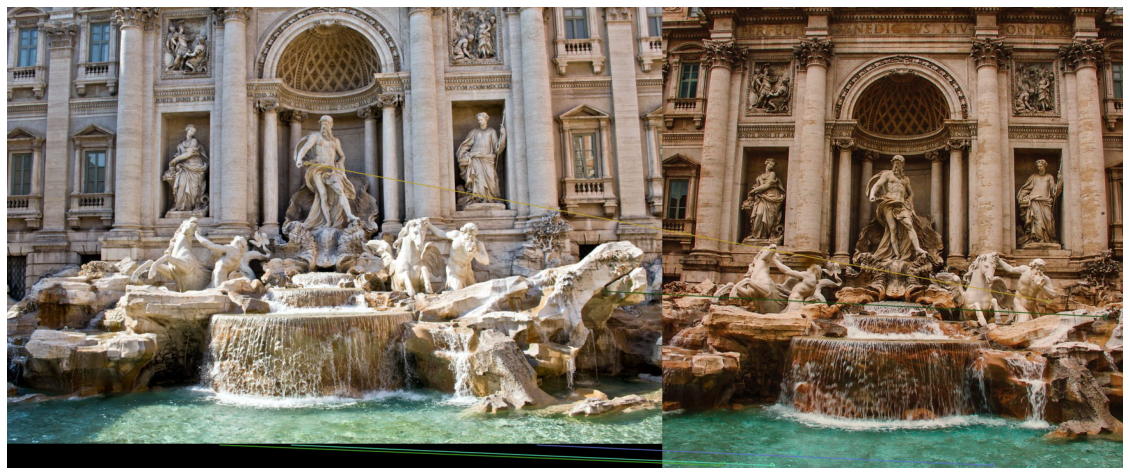

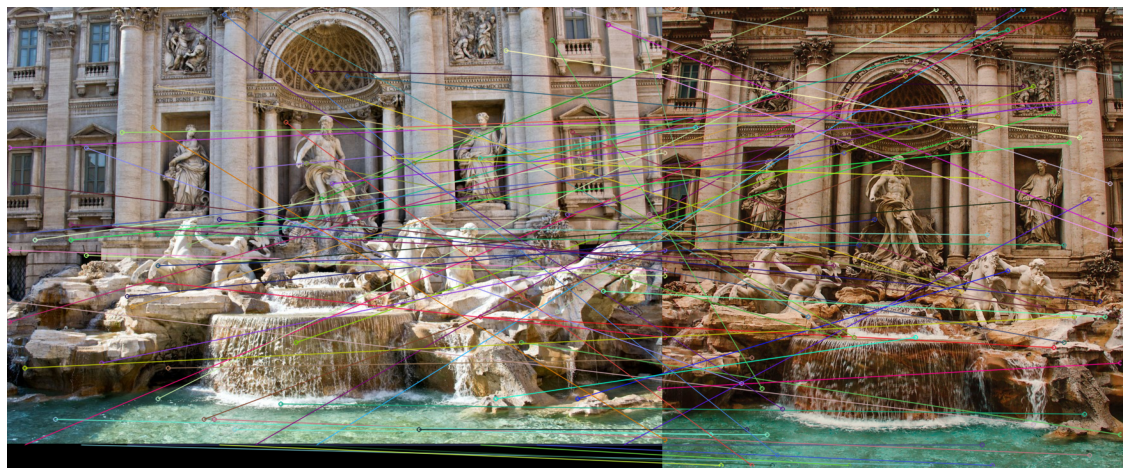

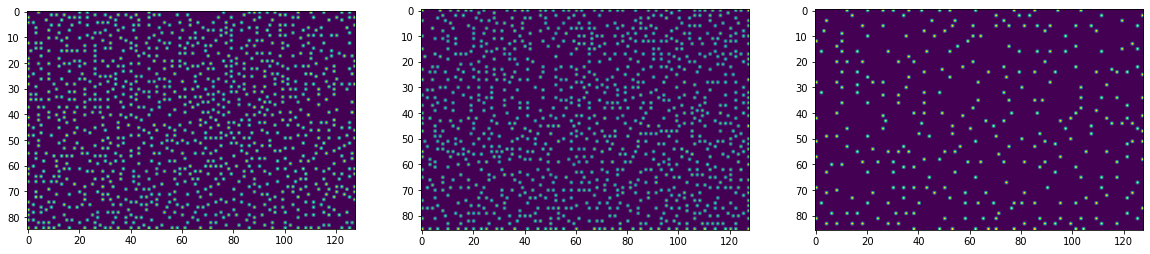

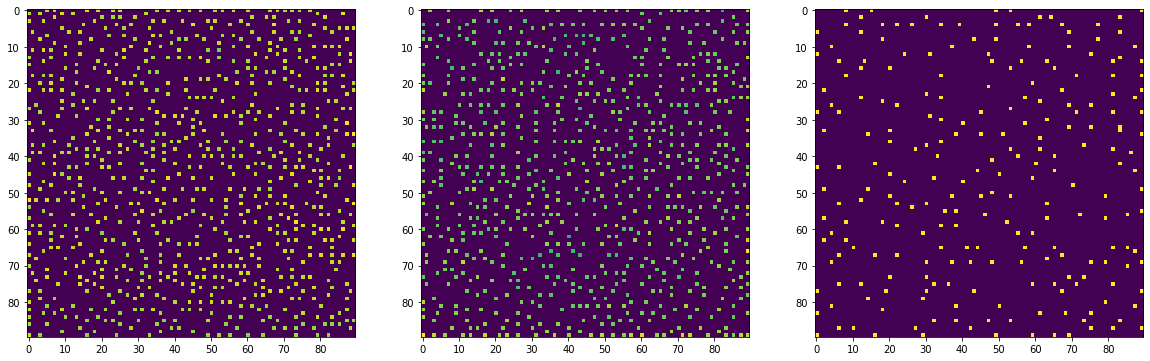

In [132]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

print(keypoints_left[inliers])
print(keypoints_right[inliers])


plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

max_pool_torch = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
def nms(x):
    x = torch.tensor(x)
    lmax = torch.squeeze(max_pool_torch(torch.unsqueeze(x, dim=0)), dim=0)
    x[lmax != x] = 0
    return x.numpy()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det1[0])
axs[1].imshow(det1[1])
axs[2].imshow(det1[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 20))
axs[0].imshow(det2[0])
axs[1].imshow(det2[1])
axs[2].imshow(det2[2])
plt.show()